In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import rebound
import reboundx
from reboundx import constants
import numpy as np
import datetime
from astropy import constants as const

years = 2.*np.pi
G = const.G.value
c = const.c.value
M_jup = const.M_jup.value
M_sun = const.M_sun.value
au = const.au.value
R_jup = const.R_jup.value
Q = 1.0e5 #tidal quality factor
k = 0.26 #tidal Love number

def makesim():
    sim = rebound.Simulation()
    sim.add(m = 0.927)
    sim.add(m = 0.0,
            a = 0.2389, #1.0,
            e = 0.4686, #0.9,
            inc = np.radians(35.614629), #np.radians(65.0),
            Omega = np.radians(0.0),
            omega = np.radians(66.0054), #np.radians(38.4),
            M = np.radians(0.698350))
    sim.add(m = 6.59*M_jup/M_sun,
            a =1.923,
            e = 0.133,
            inc = np.radians(3.3853710), #0.0,
            Omega = np.radians(180.0),
            omega = np.radians(136.865), #np.radians(17.2),
            M = np.radians(-293.214))
    return sim
    
def runsim(sim,tmax,Nout,gr=False,tides=False,integrator='ias15'):
    sim_dir = 'simulation_archive/'
    start = datetime.datetime.now()
    datetag = start.isoformat().replace('-','').replace(':','').replace('.','')[:-6]
    file = sim_dir+'sa'+datetag+'.bin'
    print("Simulation start: "+start.isoformat()+"\n")
    print("INTEGRATING . . .\n")
    
    if integrator == 'ias15':
        sim.integrator='ias15'
        sim.ri_ias15.epsilon = 0

    if integrator == 'whfast':
        sim.integrator = "whfast"
        sim.ri_whfast.safe_mode = 0

    sim.move_to_com()
    interval =  tmax/Nout
    ps = sim.particles
    rebx = reboundx.Extras(sim)
    sim.automateSimulationArchive(file,interval=interval,deletefile=True)
    
    
    if gr == True:
        gr = rebx.load_force("gr")
        rebx.add_force(gr)
        gr.params["c"] = constants.C  

    if tides == True:
        mod = rebx.load_operator("modify_orbits_direct2")
        rebx.add_operator(mod)
        tau = Q/(3.0*k)*(ps[1].m/ps[0].m)/(R_jup/au)**5
        #tau = tmax*1.5
        ps[1].params["tau_e"] = tau
        
    sim.integrate(tmax,exact_finish_time=0)
    del sim
    end = datetime.datetime.now()
    runtime = end - start
    print("\n")
    print("Simulation end: "+end.isoformat())
    print("Runtime: "+str(runtime.total_seconds())+" s")
    print("Simulation archive: "+file)
    
    

In [26]:
Nout = 1e2
tmax = 100*years


Simulation start: 2019-10-30T09:02:44.622307

INTEGRATING . . .



Simulation end: 2019-10-30T09:02:55.409317
Runtime: 10.78701 s
Simulation archive: simulation_archive/sa20191030T090244.bin
Simulation start: 2019-10-30T09:02:55.449110

INTEGRATING . . .



/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)




Simulation end: 2019-10-30T09:02:59.080893
Runtime: 3.631783 s
Simulation archive: simulation_archive/sa20191030T090255.bin


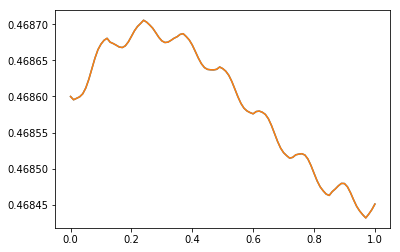

In [27]:
sim = makesim()
runsim(sim,tmax,Nout,gr=True,tides=True,integrator='ias15')   
file = 'simulation_archive/sa20191030T090035.bin'
sa = rebound.SimulationArchive(file)
e = np.zeros(len(sa))
t = np.zeros(len(sa))
for i, sim in enumerate(sa):
    e[i] = sim.particles[1].e
    t[i] = sim.t
t = t/years    
plt.plot(t,e)

sim = makesim()
runsim(sim,tmax,Nout,gr=True,tides=True,integrator='whfast')   
file = 'simulation_archive/sa20191030T090035.bin'
sa = rebound.SimulationArchive(file)
e = np.zeros(len(sa))
t = np.zeros(len(sa))
for i, sim in enumerate(sa):
    e[i] = sim.particles[1].e
    t[i] = sim.t
t = t/years    
plt.plot(t,e)

In [29]:
sim = sa[-1]
sim.particles[0].m

/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


0.927

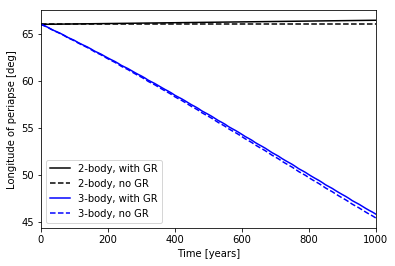

In [169]:
plt.figure()
plt.plot(t,np.degrees(pomega_gr),label="2-body, with GR",color='black')
plt.plot(t,np.degrees(pomega),label="2-body, no GR",linestyle='--',color='black')
plt.plot(t,np.degrees(pomega_gr_3),label="3-body, with GR",color='blue')
plt.plot(t,np.degrees(pomega_3),label="3-body, no GR",linestyle='--',color='blue')
#plt.plot(t,np.degrees(pomega_gr),label='GR')
plt.margins(x=0)
plt.ylabel('Longitude of periapse [deg]')
plt.xlabel('Time [years]')
plt.legend()
plt.savefig('pomega.pdf')


In [59]:
sim = rebound.Simulation("simulation.bin")
widget_1 = sim.getWidget(orientation=(0,0,0,1),scale=2)
widget_2 = sim.getWidget(orientation=(0,1,0,1),scale=2,size=(50,200))
widget_3 = sim.getWidget(orientation=(1,0,0,1),scale=2,size=(200,50))
from ipywidgets import HBox, VBox
VBox((widget_3,HBox((widget_1, widget_2))))


A Jupyter Widget

In [ ]:
sim.integrate(sim.t+100)

A Jupyter Widget

In [2]:
def bovera(a,M,Mper,e0,afcrit):
    strength = (8.*G*M*M_sun/(c**2.*a*au))**(-1./3.)*\
    (M/Mper)**(-1./3.)*\
    (2.*e0**2. + 3.*(1. - (afcrit/a)))**(1./3.)*\
    (np.sqrt(a/afcrit)-(1./np.sqrt(1.-e0**2.)))**(-1./3.)
    return strength

/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


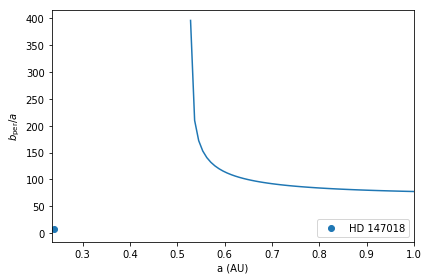

In [44]:
b2 = a2*(1.-e2**2)**(1./2.)
e0 = 0.9
Mper = M_jup/M_sun
M = 1.
afcrit = 0.1
a = np.linspace(0.15,1,100)
e = np.linspace(0.0,0.9,10)

y1 = bovera(a=a,M=m0,Mper=m2,e0=e0,afcrit=afcrit)
plt.plot(a,y1)
plt.scatter(a1,b2/a1,label = 'HD 147018')
plt.ylabel(r'$b_{\mathrm{per}}/a$')
plt.xlabel('a (AU)')
plt.tight_layout()
plt.margins(x=0)
plt.legend(loc="lower right")


In [45]:
bovera(a=1,M=m0,Mper=m2,e0=0.9,afcrit=afcrit)

77.26887540023297

1.9059161403165146